In [1]:
from pathlib import Path
import pandas as pd
from typing import Dict
import json
import torch
import torch.nn as nn
from transformers import BertTokenizer, RobertaTokenizer, DistilBertTokenizer
from torch.utils.data import DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from icr.aux import parse_id, get_mentioned_cliparts

/home/users/jspiess/miniconda3/envs/codraw_pl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', 30) 

In [3]:
df = pd.read_csv('../data/codraw-icr-v2.tsv', delimiter='\t')
df.head()

,Unnamed: 0,teller_before,drawer,teller_after,is_CR_annotator_1,do_annotators_agree,is_CR_annotator_2,mood,is_source_utterance_last_turn,next_turn_contains_response,clipart,clipart_1,clipart_2,clipart_3,clipart_4,clipart_5,position,size,direction,relation_to_other_cliparts,disambig_object,disambig_person,game_name,turn,annotation_round,freq
0,0,small sized slide on right facing left against...,is the boy on top of the slide ? beside the sl...,standing in front of it . half level w bottom ...,1,1,1,alternative question,1,1,two,boy,slide,NaN,NaN,NaN,0,0,0,1,0,0,train_07672,2,all types,1.0
1,1,a kid in a blue shirt in front of a swing set ...,they are left of right .,"kid is on left , swings behind him and sun abo...",1,1,1,alternative question,1,1,many,boy,swing,sun,NaN,NaN,1,0,0,0,0,0,train_02452,1,all types,1.0
2,2,medium boy sit on the left in the medium level...,how far is he from the edge of the grass,center of boy is about . 75 inches away from t...,1,1,1,wh-question,1,1,two,boy,background,NaN,NaN,NaN,0,0,0,1,0,0,train_02097,1,all types,1.0
3,3,boy sitting between pie and tree with winter h...,smiling or just mouth open ?,"yes , girl kneeling on right of pie",1,1,1,alternative question,1,1,one,boy,NaN,NaN,NaN,NaN,0,0,0,0,0,1,train_02685,2,all types,1.0
4,4,duck facing right . have both them with one of...,balloons and mustard in right hands ?,NaN,1,1,1,polar question,0,0,many,air_balloons,mustard,girl,boy,NaN,0,0,0,1,0,0,train_09442,3,all types,1.0


In [4]:
unique_categories = set(df[['clipart_1', 'clipart_2', 'clipart_3', 'clipart_4', 'clipart_5']].values.flatten())
unique_categories_list = [str(category).replace('_', ' ') for category in unique_categories]
print(unique_categories_list)

['baseball', 'baseball glove', 'cat', 'pirate hat', 'balloon', 'girl', 'racket', 'owl', 'slide', 'tent', 'tree', 'ketchup', 'airplane', 'glasses', 'rocket', 'soccer ball', 'hamburger', 'tree group', 'pizza', 'fire', 'crown', 'background', 'snake', 'sandbox', 'dog', 'air balloons', 'bee', 'kite', 'frisbee', 'red gray bonnet', 'tennis ball', 'cloud rain', 'ball', 'cloud lightning', 'rainbow hat helix', 'blue hat star', 'hotdog', 'duck', 'nan', 'bear', 'pie', 'table', 'cloud group', 'sun', 'hat group', 'basketball', 'boy', 'swing', 'football', 'cloud', 'mustard', 'apple tree', 'ambiguous', 'helicopter', 'viking helmet', 'grill', 'sunglasses', 'basket', 'glasses group', 'chef hat', 'shovel', 'ball group', 'pine tree', 'drink', 'baseball bat', 'witch hat']


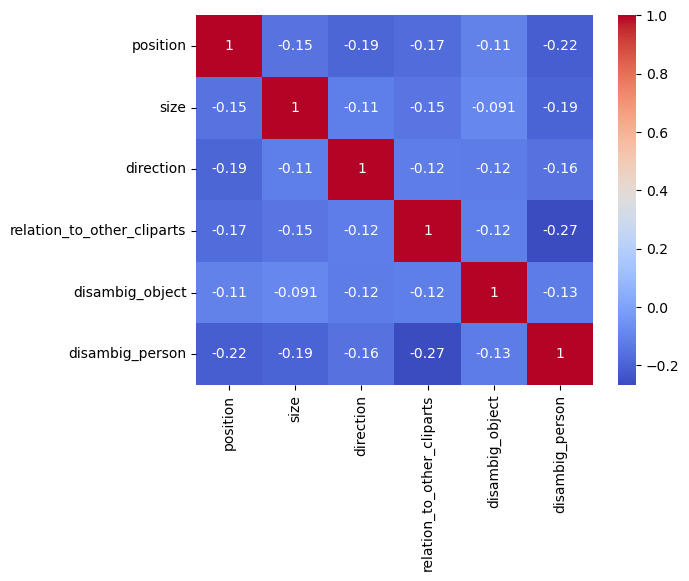

In [5]:
# Correlation Analysis
correlation_matrix = df[['position', 'size', 'direction', 'relation_to_other_cliparts', 'disambig_object', 'disambig_person']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [6]:
df_single_mood = df[df['mood'].apply(lambda x: isinstance(x, str) and ',' not in x if pd.notna(x) else True)]
df_single_mood

,Unnamed: 0,teller_before,drawer,teller_after,is_CR_annotator_1,do_annotators_agree,is_CR_annotator_2,mood,is_source_utterance_last_turn,next_turn_contains_response,clipart,clipart_1,clipart_2,clipart_3,clipart_4,clipart_5,position,size,direction,relation_to_other_cliparts,disambig_object,disambig_person,game_name,turn,annotation_round,freq
0,0,small sized slide on right facing left against...,is the boy on top of the slide ? beside the sl...,standing in front of it . half level w bottom ...,1,1,1,alternative question,1,1,two,boy,slide,NaN,NaN,NaN,0,0,0,1,0,0,train_07672,2,all types,1.0
1,1,a kid in a blue shirt in front of a swing set ...,they are left of right .,"kid is on left , swings behind him and sun abo...",1,1,1,alternative question,1,1,many,boy,swing,sun,NaN,NaN,1,0,0,0,0,0,train_02452,1,all types,1.0
2,2,medium boy sit on the left in the medium level...,how far is he from the edge of the grass,center of boy is about . 75 inches away from t...,1,1,1,wh-question,1,1,two,boy,background,NaN,NaN,NaN,0,0,0,1,0,0,train_02097,1,all types,1.0
3,3,boy sitting between pie and tree with winter h...,smiling or just mouth open ?,"yes , girl kneeling on right of pie",1,1,1,alternative question,1,1,one,boy,NaN,NaN,NaN,NaN,0,0,0,0,0,1,train_02685,2,all types,1.0
4,4,duck facing right . have both them with one of...,balloons and mustard in right hands ?,NaN,1,1,1,polar question,0,0,many,air_balloons,mustard,girl,boy,NaN,0,0,0,1,0,0,train_09442,3,all types,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8760,15294,beach ball near his hands a little above the,what size is the boy ?,maybe medium size ?,1,1,1,wh-question,0,1,one,boy,NaN,NaN,NaN,NaN,0,1,0,0,0,0,train_07502,3,repeated types in own context,NaN
8761,15295,"boy , sitting legs out , facing left , sad fac...",where do i put the boy ?,the horizon cuts into the middle of the whirly...,1,1,1,wh-question,1,1,one,boy,NaN,NaN,NaN,NaN,1,0,0,0,0,0,train_07733,4,repeated types in own context,NaN
8762,15297,of the tree sorry . girl on her knees . in fro...,is she smiling,yes . there is a large fire right to the left ...,1,1,1,polar question,1,1,one,girl,NaN,NaN,NaN,NaN,0,0,0,0,0,1,train_03740,3,repeated types in own context,NaN
8763,15298,slightly above behind and left of the girl is ...,small or large,small,1,1,1,alternative question,1,1,one,tree,NaN,NaN,NaN,NaN,0,1,0,0,0,0,train_01604,7,repeated types in own context,NaN


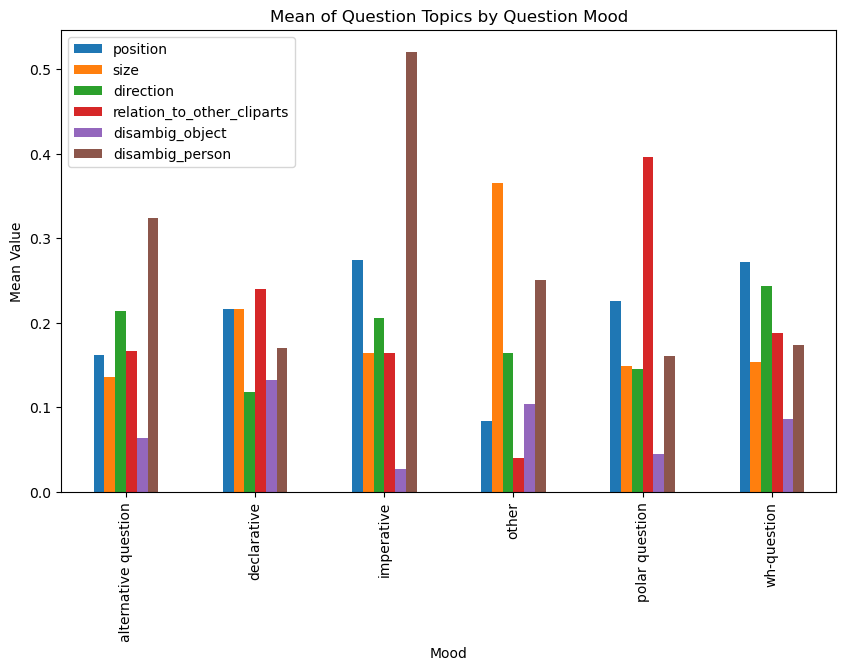

In [7]:
grouped_df = df_single_mood.groupby('mood')[['position', 'size', 'direction', 'relation_to_other_cliparts', 'disambig_object', 'disambig_person']].mean()
grouped_df.plot(kind='bar', figsize=(10, 6))
plt.title('Mean of Question Topics by Question Mood')
plt.ylabel('Mean Value')
plt.xlabel('Mood')
plt.show()

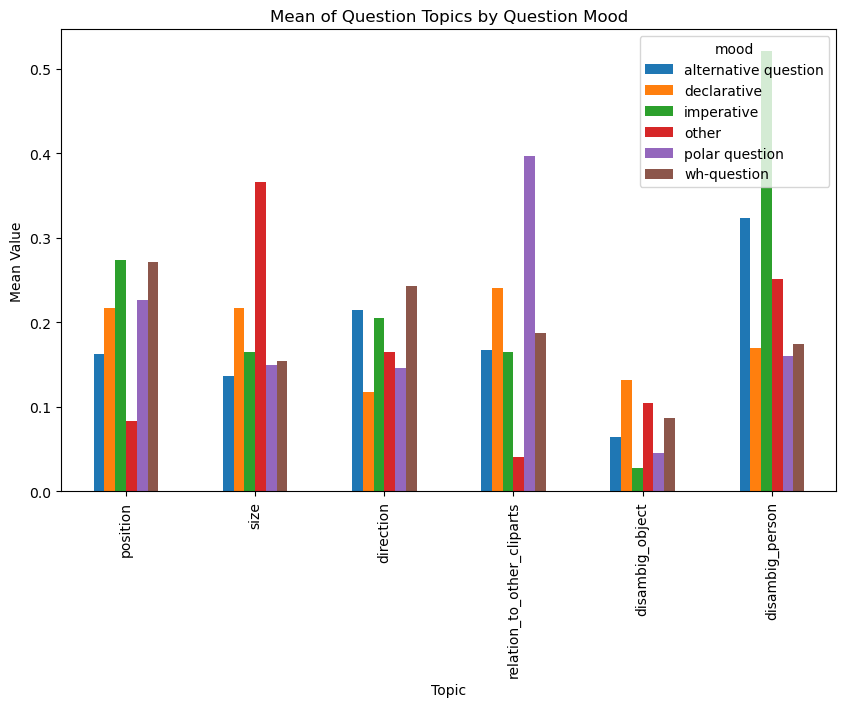

In [8]:
transposed_df = grouped_df.transpose()

transposed_df.plot(kind='bar', figsize=(10, 6))
plt.title('Mean of Question Topics by Question Mood')
plt.xlabel('Topic')
plt.ylabel('Mean Value')
plt.show()

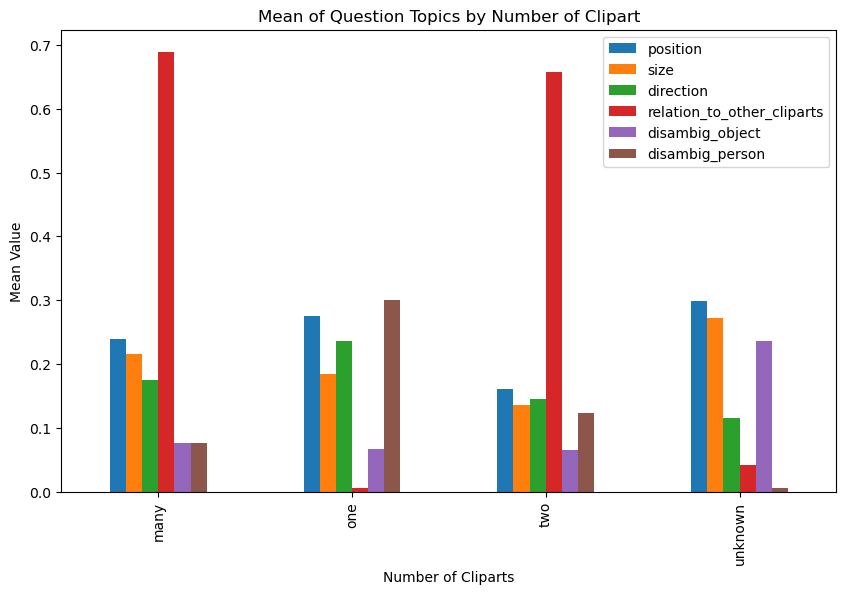

In [9]:
grouped_df = df.groupby('clipart')[['position', 'size', 'direction', 'relation_to_other_cliparts', 'disambig_object', 'disambig_person']].mean()
grouped_df.plot(kind='bar', figsize=(10, 6))
plt.title('Mean of Question Topics by Number of Clipart')
plt.ylabel('Mean Value')
plt.xlabel('Number of Cliparts')
plt.show()

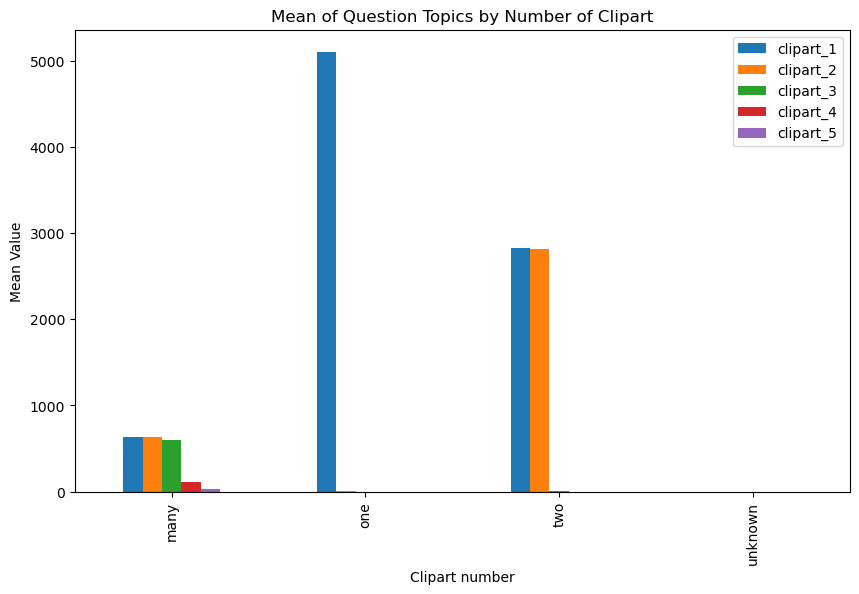

In [10]:
grouped_df = df.groupby('clipart')[['clipart_1', 'clipart_2', 'clipart_3', 'clipart_4', 'clipart_5']].count()
grouped_df.plot(kind='bar', figsize=(10, 6)) 
plt.title('Mean of Question Topics by Number of Clipart')
plt.ylabel('Mean Value')
plt.xlabel('Clipart number')
plt.show()

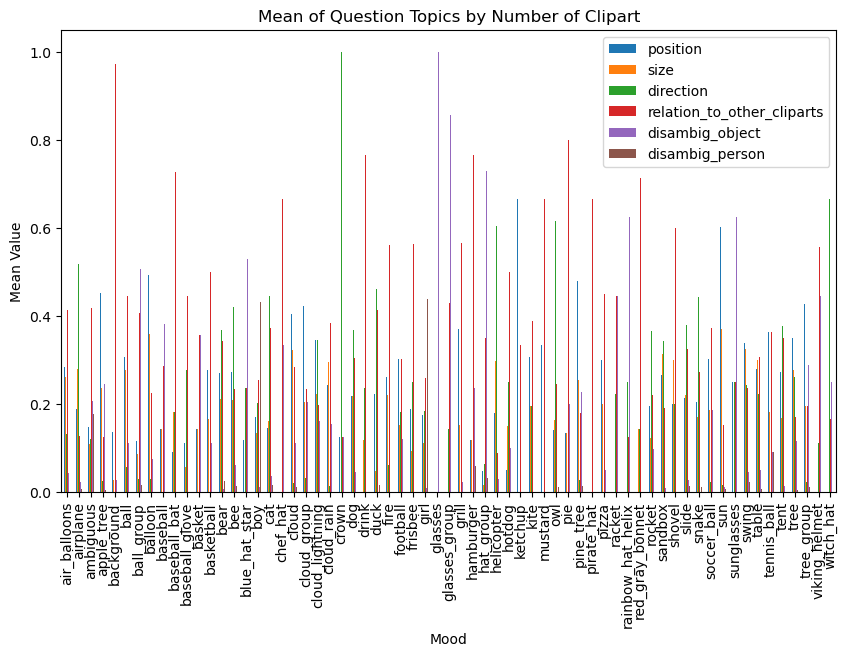

In [11]:
grouped_df = df.groupby('clipart_1')[['position', 'size', 'direction', 'relation_to_other_cliparts', 'disambig_object', 'disambig_person']].mean()
grouped_df.plot(kind='bar', figsize=(10, 6))
plt.title('Mean of Question Topics by Number of Clipart')
plt.ylabel('Mean Value')
plt.xlabel('Mood')
plt.show()

In [12]:
mood_counts = df['clipart_1'].value_counts()
print(mood_counts)

clipart_1
boy                2163
girl               2106
tree_group          353
sun                 264
tree                252
                   ... 
red_gray_bonnet       7
ketchup               3
chef_hat              3
pirate_hat            3
mustard               3
Name: count, Length: 65, dtype: int64


In [13]:
mood_counts = df['mood'].value_counts()
print(mood_counts)

mood
polar question                                     2973
wh-question                                        2592
alternative question                               1502
other                                               394
polar question,wh-question                          300
alternative question,wh-question                    260
declarative                                         212
polar question,alternative question                  86
declarative,polar question                           82
imperative                                           73
wh-question,other                                    58
declarative,wh-question                              50
polar question,alternative question,wh-question      38
polar question,other                                 32
alternative question,other                           22
declarative,alternative question                     21
declarative,other                                    10
alternative question,wh-question,other     

/tmp/ipykernel_8491/1839334633.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_mood['starting_word'] = df_single_mood['drawer'].str.split().str[0].str.lower()


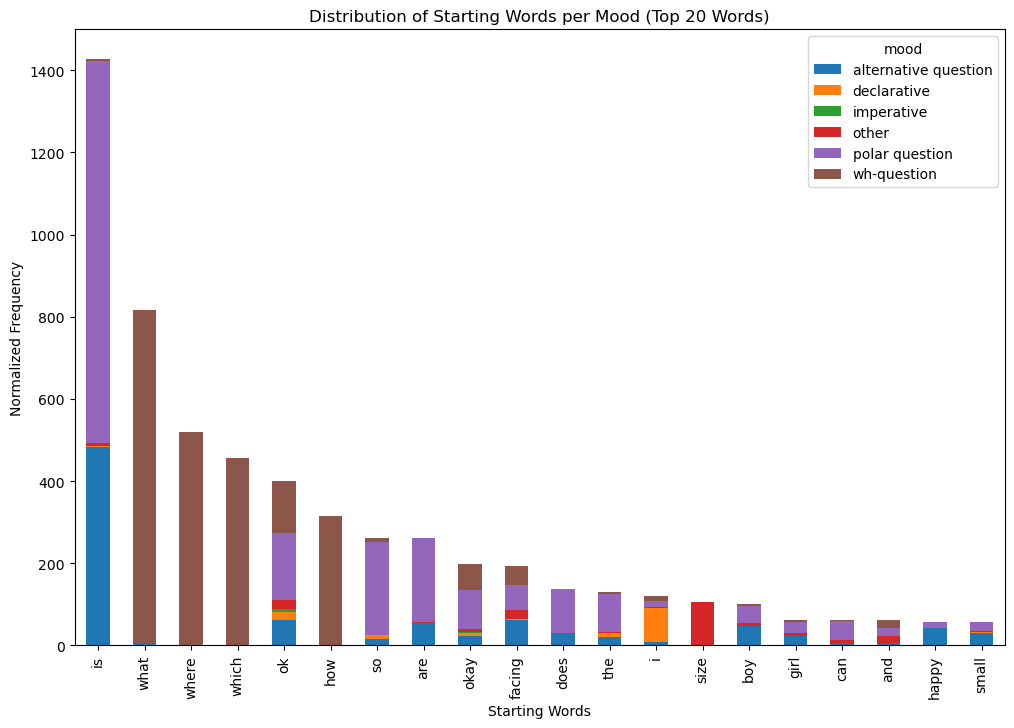

In [18]:
df_single_mood['starting_word'] = df_single_mood['drawer'].str.split().str[0].str.lower()

distribution_df = df_single_mood.groupby('mood')['starting_word'].value_counts().unstack().fillna(0)

top_words = distribution_df.sum().sort_values(ascending=False).head(20).index

distribution_df_top20 = distribution_df[top_words]

distribution_df_top20.T.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribution of Starting Words per Mood (Top 20 Words)')
plt.xlabel('Starting Words')
plt.ylabel('Normalized Frequency')
#plt.legend(title='Mood', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


/tmp/ipykernel_4755/950619773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_mood['starting_word'] = df_single_mood['drawer'].str.split().str[1].str.lower()


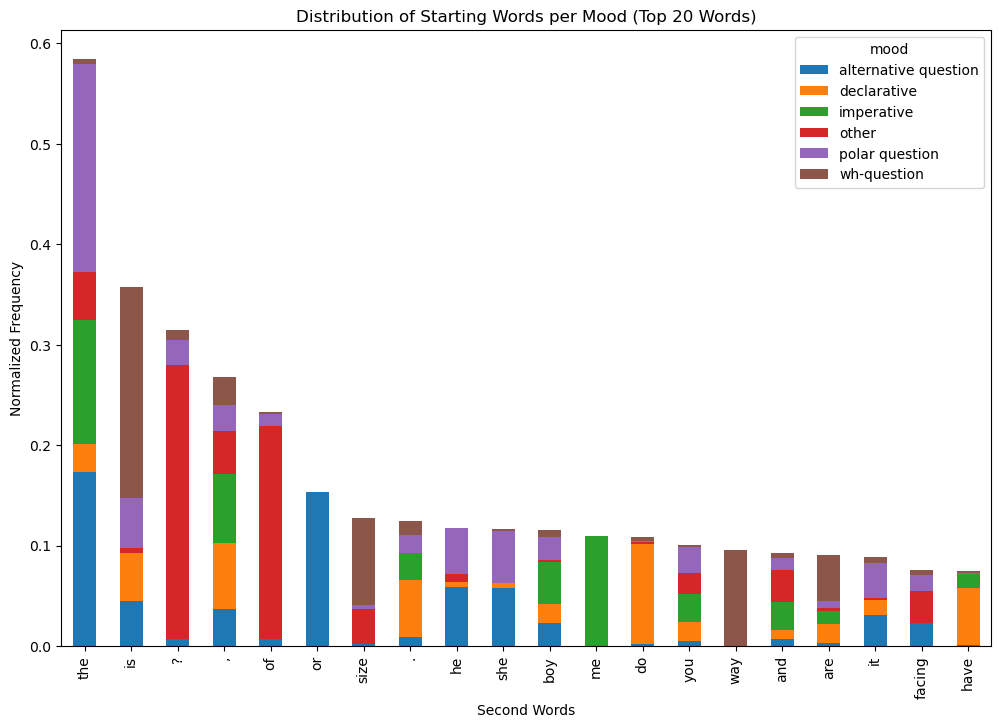

In [16]:
df_single_mood['starting_word'] = df_single_mood['drawer'].str.split().str[1].str.lower()

distribution_df = df_single_mood.groupby('mood')['starting_word'].value_counts(normalize=True).unstack().fillna(0)

top_words = distribution_df.sum().sort_values(ascending=False).head(20).index

distribution_df_top20 = distribution_df[top_words]

# Plot the distribution
distribution_df_top20.T.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribution of Starting Words per Mood (Top 20 Words)')
plt.xlabel('Second Words')
plt.ylabel('Normalized Frequency')
#plt.legend(title='Mood', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


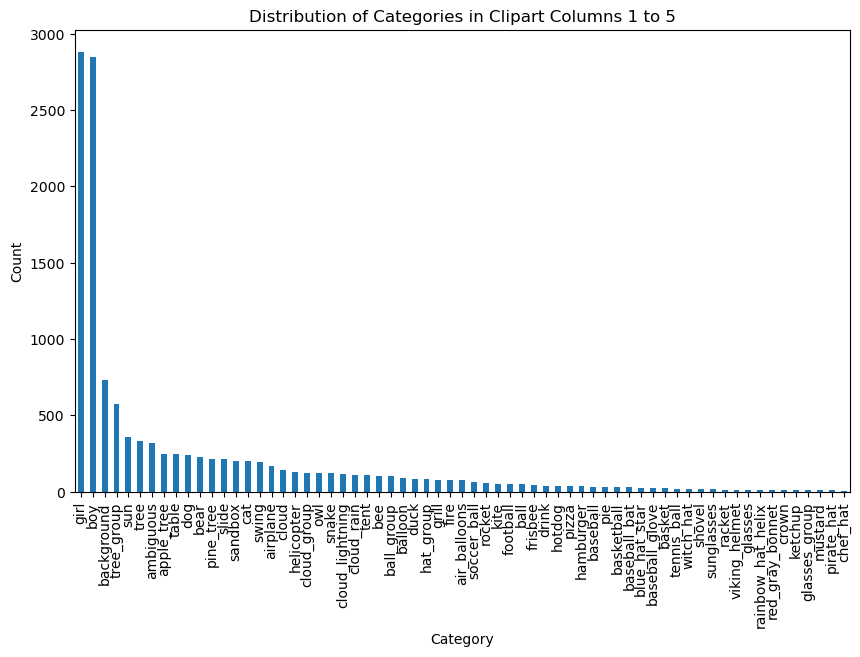

In [41]:
combined_categories = df[['clipart_1', 'clipart_2', 'clipart_3', 'clipart_4', 'clipart_5']].stack()

category_counts = combined_categories.value_counts()

category_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Categories in Clipart Columns 1 to 5')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


In [43]:
categories = set(df[['clipart_1', 'clipart_2', 'clipart_3', 'clipart_4', 'clipart_5']].values.flatten())
categories_list = [str(category).replace('_', ' ') for category in categories]
len(categories_list)

66